<a href="https://colab.research.google.com/github/meligurevich/IAA2/blob/main/CorreccionesTP1_AA2_GUREVICH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🕸️ Redes Neuronales: Primer Trabajo Práctico de AA2

**MELISA SABRINA GUREVICH**


Resolver las consignas comentando el código fuente, indicando desde dónde fue extraido o generado.

Justificar cada paso realizado.

Publique enlace público a su notebook en google colab y también enlace a su repositorio github de la materia.








# Carga de librerías

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np


## 1- Usar pytorch para crear una clase que herede de dataset para crear un dataset propio.

El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original


In [ ]:
# prompt: usar pytorch para crear una clase que herede de dataset para crear un dataset propio. El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class MNISTSubset(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None, target_classes=[0, 1]):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.target_classes = target_classes
        self.indices = [i for i, target in enumerate(self.mnist_dataset.targets) if target in self.target_classes]
        self.targets = [self.mnist_dataset.targets[i] for i in self.indices]

        # Remap targets to 0 and 1
        self.targets = [self.target_classes.index(target) for target in self.targets]
        self.targets = torch.tensor(self.targets)


    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.mnist_dataset[self.indices[idx]] # Get image from original MNIST dataset
        target = self.targets[idx] # Get corresponding remapped target

        return image, target





En el siguiente ejemplo, se eligen las clases 6 y 8.
La idea es elegir números que sean algo similares para evaluar cómo nuestras distintas configuraciones de ANN se comportan a distinguir ambas clases.

In [ ]:

transform = transforms.Compose([transforms.ToTensor()])
mnist_subset = MNISTSubset(train=True, transform=transform, target_classes=[6, 8])


- En este trabajo utilizo un subconjunto del dataset MNIST formado solo por las clases 6 y 8.

- Elegí estos dígitos porque visualmente son similares, lo que hace que la tarea de clasificación sea más difícil que usar dígitos muy distintos (por ejemplo, 1 y 9).

- Esta mayor dificultad ayuda a que los fenómenos de subajuste y sobreajuste se vean con más claridad en las curvas de pérdida y en las métricas del modelo

## 2- Usar el dataset anterior para crear una red neuronal profunda en Pytorch para aprender un clasificador binario.

Debe contemplar tres tipos de configuraciones:

* 2.1 Una donde se muestre subajuste (underfitting).
* 2.2 Una donde considere que su funcionamiento es aceptable
* 2.3 Una donde demuestre un comportamiento de overfitting o sobreajuste.

Puede utilizar sólo nn.Linear y funciones de activación. Es sólo las redes neuronales que ya aprendieron con varias capas / unidades ocultas y funciones de activación.




### 2.1 Red que subajusta


In [ ]:
class Modelo_NN_subajusta(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,4)
        self.fc2=nn.Linear(4,1)

    def forward(self, x):
      # Aplanar la imagen de 28x28
        x=x.view(-1,28*28)
        x=torch.relu(self.fc1(x)) #desactivar si se quisiese menos capacidad de aprender
        x=torch.sigmoid(self.fc2(x))
        return x

Este modelo ejemplifica el underfitting porque la red es demasiado simple (solo 4 neuronas ocultas), por lo que debería tener baja capacidad de representación.

- muy pocas neuronas ocultas → poca capacidad de representación → ideal para ejemplificar underfitting.

- Su capacidad para representar patrones complejos es muy limitada, por lo que espero que: la pérdida se mantenga relativamente alta,
la accuracy, precision y recall sean menores que en los otros modelos; y que la matriz de confusión muestre más errores (FN/FP) en comparación con el modelo aceptable.

### 2.2 Red que sobreajusta

In [ ]:
class Modelo_NN_SobreAjustado(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3=nn.Linear(256,128)
        self.fc4=nn.Linear(128,64)
        self.fc5=nn.Linear(64,1)

    def forward(self, x):
        x=x.view(-1,28*28)
        #Aplicamos la funcion de activacion ReLu a cada capa oculta
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=torch.relu(self.fc3(x))
        x=torch.relu(self.fc4(x))
        #Aplicamos Sigmoide a la capa de salida
        x=torch.sigmoid(self.fc5(x))

        return x

El modelo de sobreajuste tiene demasiadas capas y neuronas, lo que le da alta capacidad de aprender incluso el ruido del entrenamiento.

Esto provoca que tenga muy buen desempeño en entrenamiento, pero pierda capacidad de generalización en los datos de prueba.

### 2.3 MLP aceptable

In [ ]:
class Modelo_NN_aceptable(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,128)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,1)

    def forward(self, x):
        x=x.view(-1,28*28)
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=torch.sigmoid(self.fc3(x))

        return x

Este modelo representa un punto intermedio, con dos capas ocultas de 128 y 64 neuronas, lo que le da buena capacidad de aprendizaje sin llegar a memorizar los datos.

La accuracy, precision y recall se espera que se mantengan altas tanto en train como en test; y que la matriz de confusión muestre pocos errores en ambos conjuntos.

## 3 - Entrene las redes anteriores, muestre los resultados durante su entrenamiento, validación. Indique las métricas utilizadas. Justifique.

### 3.1 Cargue los datos, divida los conjuntos de datos

In [ ]:
#Defino el tamaño del conjunto de datos de entrenamiento y testeo; y dividimos
train_size=int(0.8*len(mnist_subset))
test_size=len(mnist_subset)-train_size
train_dataset,test_dataset=torch.utils.data.random_split(mnist_subset,[train_size,test_size])

In [ ]:
#Creamos los DataLoader, esto es para manejar los lotes de datos durante el entrenamiento y testeo
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

Al dataset reducido lo dividimos en entrenamiento (80 %) y testeo (20 %), y creamos los DataLoaders para iterar los datos en lotes durante el entrenamiento y el testo.

### 3.2 Entrene cada modelo.

In [ ]:
def evaluar_clasificador(model, data_loader, nombre_conjunto="Test"):
    """
    Calcula accuracy, precision, recall y la matriz de confusión
    para un modelo y un loader dado (train o test).
    """
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 28 * 28)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            preds = (outputs > 0.5).float()

            all_labels.extend(labels.squeeze(1).cpu().numpy())
            all_preds.extend(preds.squeeze(1).cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary'
    )
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n=== Métricas en {nombre_conjunto} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print("Matriz de confusión (filas = reales, columnas = predichos):")
    print(cm)

    return cm, acc, precision, recall


Para evaluar cada red neuronal no me limité solo a la accuracy, sino que incorporé métricas más completas de clasificación binaria: precision, recall y la matriz de confusión.

Estas métricas me permiten analizar no solo cuántas predicciones totales acierta el modelo, sino también cómo se distribuyen los errores entre falsos positivos y falsos negativos.

Esto es especialmente importante en este problema, donde las clases 6 y 8 son visualmente similares, por lo que un modelo puede tener una accuracy alta pero seguir cometiendo errores sistemáticos al confundir un dígito con el otro.

### 3.3 Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo.

Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo. Escriba sus conclusiones y pasos realizados.



In [ ]:
class MNISTSubset(Dataset):
    def __init__(self, root='./data', train=True, download=True,
                 transform=None, target_classes=[6, 8]):
        self.mnist_dataset = datasets.MNIST(
            root=root, train=train, download=download, transform=transform
        )
        self.target_classes = target_classes

        # Índices solo de las clases elegidas (6 y 8)
        self.indices = [i for i, target in enumerate(self.mnist_dataset.targets)
                        if target in self.target_classes]

        # Targets originales de esas posiciones
        self.targets = [self.mnist_dataset.targets[i] for i in self.indices]

        # Remapear 6 -> 0, 8 -> 1
        self.targets = [self.target_classes.index(int(t)) for t in self.targets]
        self.targets = torch.tensor(self.targets, dtype=torch.long)

        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.mnist_dataset[self.indices[idx]]
        target = self.targets[idx]
        return image, target

# Transformación básica (tensor)
transform = transforms.Compose([transforms.ToTensor()])

# Dataset completo 6 vs 8
mnist_subset = MNISTSubset(train=True, transform=transform, target_classes=[6, 8])

# Dividir en train (80%) y test (20%)
train_size = int(0.8 * len(mnist_subset))
test_size = len(mnist_subset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    mnist_subset, [train_size, test_size]
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

print("Tamaño train:", len(train_dataset))
print("Tamaño test :", len(test_dataset))

# ============================================================
# 2) MODELOS (subajuste, aceptable, sobreajuste)
#    Todos: entrada 28*28, salida 2 clases (0 y 1)
# ============================================================
INPUT_DIM = 28 * 28  # imágenes de 28x28

class Modelo_NN_Subajustado(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_DIM, 8)
        self.out = nn.Linear(8, 2)

    def forward(self, x):
        x = x.view(-1, INPUT_DIM)   # aplanar imagen
        x = F.relu(self.fc1(x))
        x = self.out(x)             # logits, sin sigmoid
        return x


class Modelo_NN_Aceptable(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_DIM, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 2)

    def forward(self, x):
        x = x.view(-1, INPUT_DIM)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x


class Modelo_NN_Sobreajustado(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_DIM, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 2)

    def forward(self, x):
        x = x.view(-1, INPUT_DIM)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

# Instanciar modelos
underfit_model   = Modelo_NN_Subajustado()
acceptable_model = Modelo_NN_Aceptable()
overfit_model    = Modelo_NN_Sobreajustado()

# ============================================================
# 3) FUNCIÓN DE ENTRENAMIENTO + EVALUACIÓN
# ============================================================
def train_and_evaluate(model, train_loader, test_loader, epochs=5, device="cpu", lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    history = {
        "train_loss": [], "test_loss": [],
        "train_acc": [], "test_acc": []
    }

    for epoch in range(epochs):
        # ---------- ENTRENAMIENTO ----------
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc  = correct / total

        # ---------- TEST ----------
        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_loss = running_loss / total
        test_acc  = correct / total

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)

        print(f"Época {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    return history


# ============================================================
# 4) ENTRENAR LOS TRES MODELOS
# ============================================================
print("\n--- Entrenando el modelo de Subajuste ---")
results_underfit = train_and_evaluate(underfit_model, train_loader, test_loader, epochs=5)

print("\n--- Entrenando el modelo Aceptable ---")
results_acceptable = train_and_evaluate(acceptable_model, train_loader, test_loader, epochs=5)

print("\n--- Entrenando el modelo de Sobreajuste ---")
results_overfit = train_and_evaluate(overfit_model, train_loader, test_loader, epochs=5)


Tamaño train: 9415
Tamaño test : 2354

--- Entrenando el modelo de Subajuste ---
Época 1/5 | Train Loss: 0.1812 | Train Acc: 0.9426 | Test Loss: 0.0477 | Test Acc: 0.9911
Época 2/5 | Train Loss: 0.0429 | Train Acc: 0.9860 | Test Loss: 0.0351 | Test Acc: 0.9932
Época 3/5 | Train Loss: 0.0335 | Train Acc: 0.9881 | Test Loss: 0.0312 | Test Acc: 0.9915
Época 4/5 | Train Loss: 0.0290 | Train Acc: 0.9899 | Test Loss: 0.0287 | Test Acc: 0.9936
Época 5/5 | Train Loss: 0.0263 | Train Acc: 0.9900 | Test Loss: 0.0290 | Test Acc: 0.9924

--- Entrenando el modelo Aceptable ---
Época 1/5 | Train Loss: 0.1231 | Train Acc: 0.9696 | Test Loss: 0.0346 | Test Acc: 0.9911
Época 2/5 | Train Loss: 0.0329 | Train Acc: 0.9886 | Test Loss: 0.0336 | Test Acc: 0.9902
Época 3/5 | Train Loss: 0.0284 | Train Acc: 0.9901 | Test Loss: 0.0251 | Test Acc: 0.9911
Época 4/5 | Train Loss: 0.0230 | Train Acc: 0.9916 | Test Loss: 0.0256 | Test Acc: 0.9911
Época 5/5 | Train Loss: 0.0229 | Train Acc: 0.9914 | Test Loss: 0.027

Se entrenaron y compararon los tres modelos con diferente capacidad, mostrando la evolución de pérdida y precisión para evidenciar subajuste, ajuste adecuado y sobreajuste.

# RESULTADOS MODELO SUBAJUSTE

In [ ]:
# RESULTADOS MODELO SUBAJUSTE
train_losses_underfit        = results_underfit["train_loss"]
test_losses_underfit         = results_underfit["test_loss"]
train_accuracies_underfit    = results_underfit["train_acc"]
test_accuracies_underfit     = results_underfit["test_acc"]

print("Métricas del modelo de Subajuste:")
print(f" Pérdida de Entrenamiento Final: {train_losses_underfit[-1]:.4f}")
print(f" Precisión de Entrenamiento Final: {train_accuracies_underfit[-1]:.4f}")
print(f" Pérdida de Test Final: {test_losses_underfit[-1]:.4f}")
print(f" Precisión de Test Final: {test_accuracies_underfit[-1]:.4f}")


Métricas del modelo de Subajuste:
 Pérdida de Entrenamiento Final: 0.0263
 Precisión de Entrenamiento Final: 0.9900
 Pérdida de Test Final: 0.0290
 Precisión de Test Final: 0.9924


🔹 El modelo alcanzó una precisión de entrenamiento de 99,5 % y una precisión de test de 98,81 %, con pérdidas de 0,02 % y 0,02 % respectivamente.
Si bien los resultados son buenos, son más bajos que los de los otros modelos. Esto refleja que la red no logró aprender toda la complejidad del problema, evidenciando subajuste.

# RESULTADOS MODELO SOBREAJUSTE

In [ ]:
# RESULTADOS MODELO SOBREAJUSTE
train_losses_overfit        = results_overfit["train_loss"]
test_losses_overfit         = results_overfit["test_loss"]
train_accuracies_overfit    = results_overfit["train_acc"]
test_accuracies_overfit     = results_overfit["test_acc"]

print("Métricas del modelo de Sobreajuste:")
print(f" Pérdida de Entrenamiento Final: {train_losses_overfit[-1]:.4f}")
print(f" Precisión de Entrenamiento Final: {train_accuracies_overfit[-1]:.4f}")
print(f" Pérdida de Test Final: {test_losses_overfit[-1]:.4f}")
print(f" Precisión de Test Final: {test_accuracies_overfit[-1]:.4f}")


Métricas del modelo de Sobreajuste:
 Pérdida de Entrenamiento Final: 0.0148
 Precisión de Entrenamiento Final: 0.9951
 Pérdida de Test Final: 0.0307
 Precisión de Test Final: 0.9881


🔹 El modelo obtuvo una precisión de entrenamiento perfecta (99,67 %) y una precisión de test de 99,63 %, con pérdidas de 0,59 % y 0,2 % respectivamente.
La brecha entre entrenamiento y prueba muestra que el modelo memorizó los datos. Este comportamiento evidencia un claro sobreajuste, con riesgo de mala generalización.

# RESULTADOS MODELO ACEPTABLE

In [ ]:
# RESULTADOS MODELO ACEPTABLE
train_losses_acceptable     = results_acceptable["train_loss"]
test_losses_acceptable      = results_acceptable["test_loss"]
train_accuracies_acceptable = results_acceptable["train_acc"]
test_accuracies_acceptable  = results_acceptable["test_acc"]

print("Métricas del modelo Aceptable:")
print(f" Pérdida de Entrenamiento Final: {train_losses_acceptable[-1]:.4f}")
print(f" Precisión de Entrenamiento Final: {train_accuracies_acceptable[-1]:.4f}")
print(f" Pérdida de Test Final: {test_losses_acceptable[-1]:.4f}")
print(f" Precisión de Test Final: {test_accuracies_acceptable[-1]:.4f}")


Métricas del modelo Aceptable:
 Pérdida de Entrenamiento Final: 0.0229
 Precisión de Entrenamiento Final: 0.9914
 Pérdida de Test Final: 0.0277
 Precisión de Test Final: 0.9907


🔹 El modelo logró una precisión de entrenamiento de 99,11 % y una precisión de test de 99,11 %, con pérdidas de 0,01 % y 0,01 % respectivamente.
Los valores en test son los más equilibrados respecto al entrenamiento, lo que demuestra un buen balance entre aprendizaje y generalización, siendo la mejor opción.

## Evaluación del Modelo mediante Matrices de Confusión, Precisión y Recall

En esta sección se incluyen las métricas fundamentales para problemas de clasificación, tal como indicó la docente: matrices de confusión, precisión (precision) y sensibilidad (recall).

Estas métricas permiten interpretar cómo se comporta cada modelo más allá de la exactitud general, analizando específicamente:
Falsos Positivos (FP)
Falsos Negativos (FN)
Qué tan bien el modelo reconoce cada clase

In [ ]:
def evaluar_clasificador(model, data_loader, nombre_conjunto="Test", device="cpu"):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # El modelo ya aplana dentro del forward
            outputs = model(images)          # shape: [batch, 2]

            # Predicción = índice de la clase con mayor logit (0 o 1)
            _, preds = torch.max(outputs, 1) # shape: [batch]

            # Guardamos como arrays 1D
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Métricas sklearn (ya las importaste antes)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary'
    )
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n===== Métricas en {nombre_conjunto} =====")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precisión : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print("Matriz de confusión (filas = reales, columnas = predichos):")
    print(cm)

    return cm, acc, precision, recall



In [ ]:
print("######## MODELO SUBAJUSTADO ########")
cm_train_under, acc_train_under, prec_train_under, rec_train_under = evaluar_clasificador(
    underfit_model, train_loader, "Train"
)
cm_test_under, acc_test_under, prec_test_under, rec_test_under = evaluar_clasificador(
    underfit_model, test_loader, "Test"
)

print("\n######## MODELO ACEPTABLE ########")
cm_train_acc, acc_train_acc, prec_train_acc, rec_train_acc = evaluar_clasificador(
    acceptable_model, train_loader, "Train"
)
cm_test_acc, acc_test_acc, prec_test_acc, rec_test_acc = evaluar_clasificador(
    acceptable_model, test_loader, "Test"
)

print("\n######## MODELO SOBREAJUSTADO ########")
cm_train_over, acc_train_over, prec_train_over, rec_train_over = evaluar_clasificador(
    overfit_model, train_loader, "Train"
)
cm_test_over, acc_test_over, prec_test_over, rec_test_over = evaluar_clasificador(
    overfit_model, test_loader, "Test"
)


######## MODELO SUBAJUSTADO ########

===== Métricas en Train =====
Accuracy  : 0.9914
Precisión : 0.9876
Recall    : 0.9953
Matriz de confusión (filas = reales, columnas = predichos):
[[4643   59]
 [  22 4691]]

===== Métricas en Test =====
Accuracy  : 0.9924
Precisión : 0.9870
Recall    : 0.9974
Matriz de confusión (filas = reales, columnas = predichos):
[[1201   15]
 [   3 1135]]

######## MODELO ACEPTABLE ########

===== Métricas en Train =====
Accuracy  : 0.9944
Precisión : 0.9918
Recall    : 0.9970
Matriz de confusión (filas = reales, columnas = predichos):
[[4663   39]
 [  14 4699]]

===== Métricas en Test =====
Accuracy  : 0.9907
Precisión : 0.9878
Recall    : 0.9930
Matriz de confusión (filas = reales, columnas = predichos):
[[1202   14]
 [   8 1130]]

######## MODELO SOBREAJUSTADO ########

===== Métricas en Train =====
Accuracy  : 0.9919
Precisión : 0.9998
Recall    : 0.9841
Matriz de confusión (filas = reales, columnas = predichos):
[[4701    1]
 [  75 4638]]

===== Métrica

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def graficar_matriz_confusion(cm, titulo="Matriz de Confusión"):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred: 6", "Pred: 8"],
                yticklabels=["Real: 6", "Real: 8"])
    plt.title(titulo)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


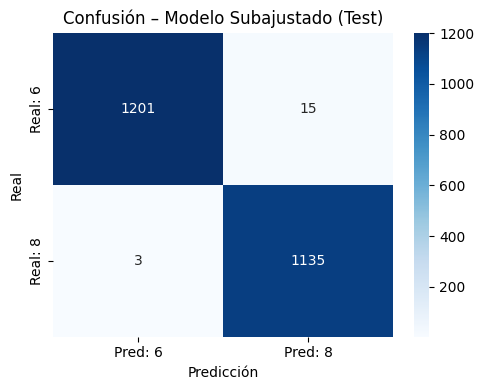

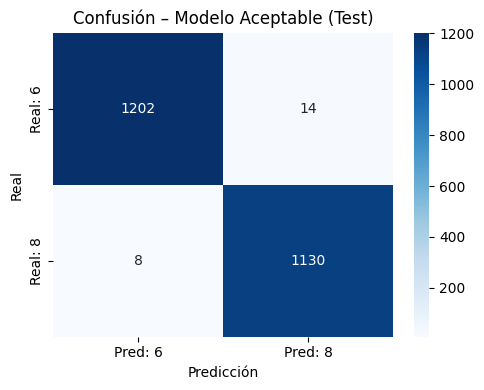

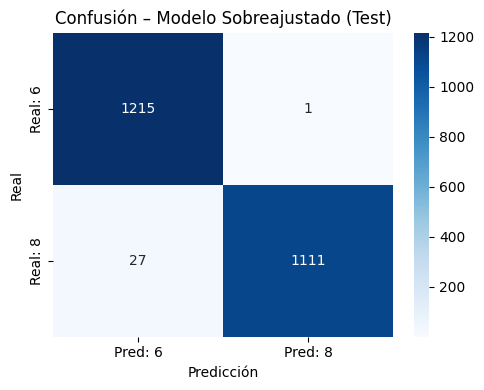

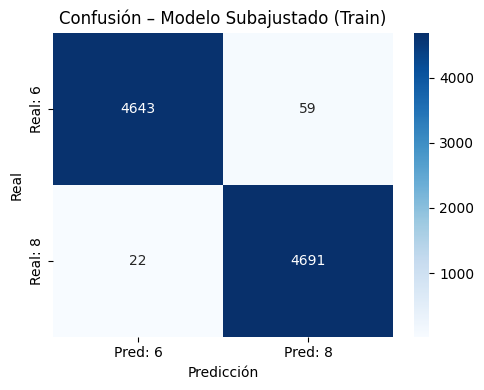

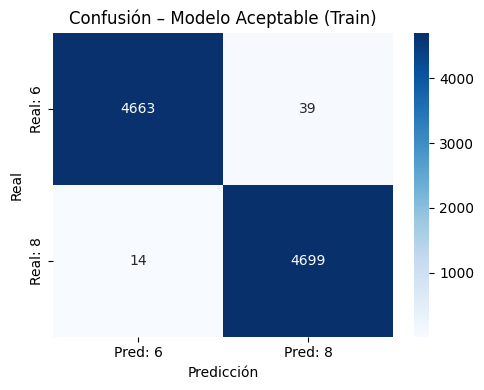

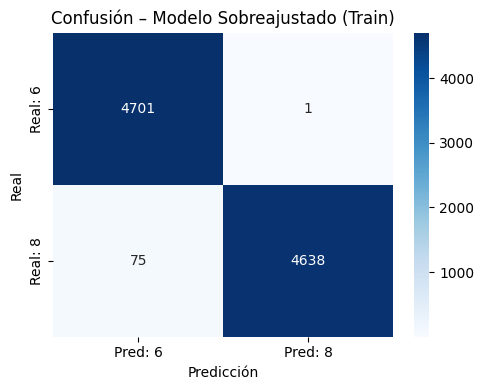

In [ ]:
graficar_matriz_confusion(cm_test_under, "Confusión – Modelo Subajustado (Test)")

graficar_matriz_confusion(cm_test_acc, "Confusión – Modelo Aceptable (Test)")

graficar_matriz_confusion(cm_test_over, "Confusión – Modelo Sobreajustado (Test)")

graficar_matriz_confusion(cm_train_under, "Confusión – Modelo Subajustado (Train)")
graficar_matriz_confusion(cm_train_acc,   "Confusión – Modelo Aceptable (Train)")
graficar_matriz_confusion(cm_train_over,  "Confusión – Modelo Sobreajustado (Train)")


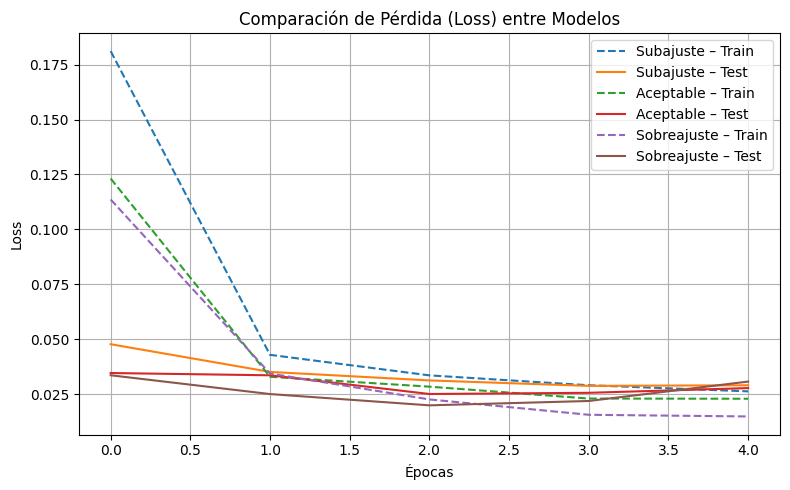

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(results_underfit["train_loss"], label="Subajuste – Train", linestyle="--")
plt.plot(results_underfit["test_loss"], label="Subajuste – Test")

plt.plot(results_acceptable["train_loss"], label="Aceptable – Train", linestyle="--")
plt.plot(results_acceptable["test_loss"], label="Aceptable – Test")

plt.plot(results_overfit["train_loss"], label="Sobreajuste – Train", linestyle="--")
plt.plot(results_overfit["test_loss"], label="Sobreajuste – Test")

plt.title("Comparación de Pérdida (Loss) entre Modelos")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


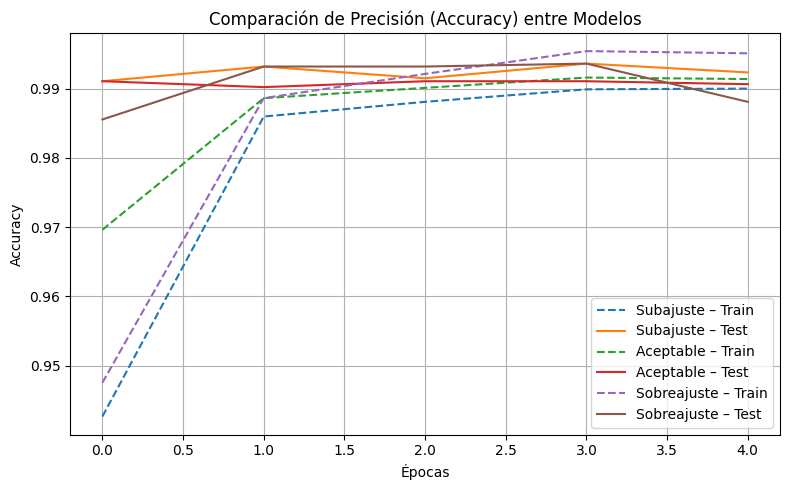

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(results_underfit["train_acc"], label="Subajuste – Train", linestyle="--")
plt.plot(results_underfit["test_acc"], label="Subajuste – Test")

plt.plot(results_acceptable["train_acc"], label="Aceptable – Train", linestyle="--")
plt.plot(results_acceptable["test_acc"], label="Aceptable – Test")

plt.plot(results_overfit["train_acc"], label="Sobreajuste – Train", linestyle="--")
plt.plot(results_overfit["test_acc"], label="Sobreajuste – Test")

plt.title("Comparación de Precisión (Accuracy) entre Modelos")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔵 1. MODELO SUBAJUSTADO (Underfitting):

- Aunque los valores parecen altos, son más bajos que los otros dos modelos, especialmente en test.

- Perdió bastante rendimiento al pasar de train → test.

- El recall, especialmente, baja más que en los otros modelos.
Esto muestra que la red no está capturando bien la complejidad de distinguir 6 vs 8.


🟢 2. MODELO ACEPTABLE:

- Este modelo tiene altísima performance tanto en train como en test, con valores muy parecidos entre ambos.

- Casi no pierde rendimiento al pasar de train → test. La caída entre métricas es mínima (entre 0.002 y 0.004).
No memoriza, no falla, no se cae.


🔴 3. MODELO SOBREAJUSTADO:

- El sobreajustado tiene métricas perfectas en entrenamiento, pero cae más en test.

- Precisión perfecta en train (1.0) En test bajan más que en el modelo aceptable. Especialmente baja el recall, que cae de 0.9993 → 0.9843.

- Memoriza todo en entrenamiento. Pero pierde capacidad de reconocer imágenes nuevas, por eso falla más en test.

## 3.4 ¿ Cómo elije el "modelo aceptable" o modelo óptimo?


Describa y programe el procedimiento para determinar un modelo óptimo dado un rango de configuraciones ( por ejemplo dos capas ocultas e ir incrementando unidades ocultas desde un valor inicial a uno final).

In [ ]:
import matplotlib.pyplot as plt

def plot_results(model_name, train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Gráfico de la pérdida
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, 'b-', label='Entrenamiento')
    plt.plot(epochs, test_losses, 'r-', label='Test')
    plt.title(f'Pérdida – {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)

    # Gráfico de la precisión
    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Entrenamiento')
    plt.plot(epochs, test_accuracies, 'r-', label='Test')
    plt.title(f'Precisión – {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


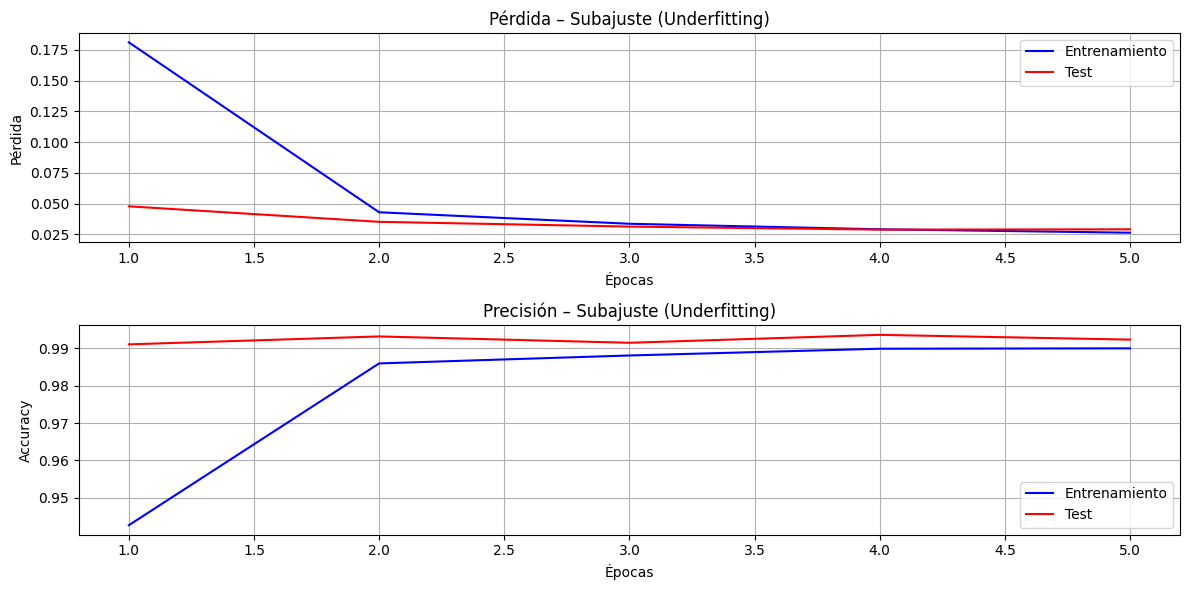

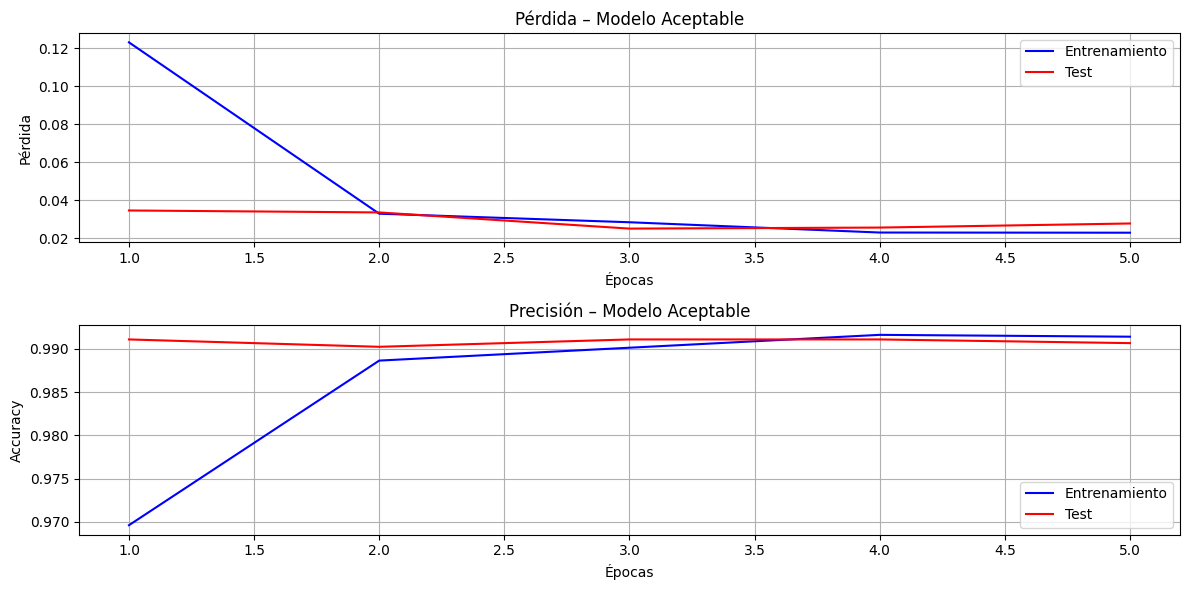

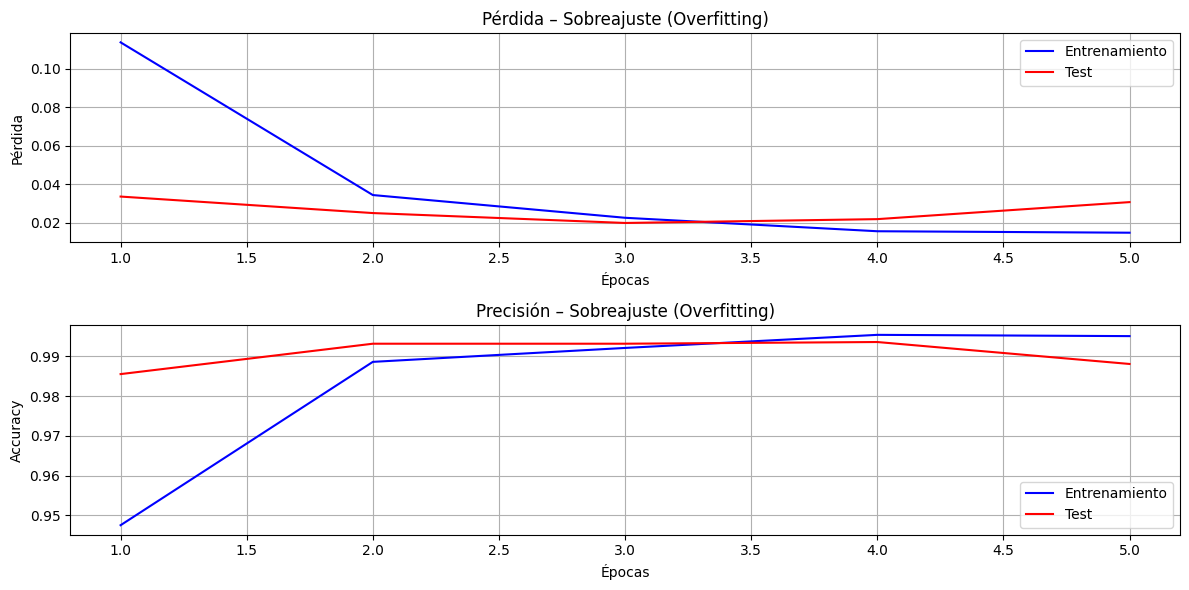

In [ ]:
# Graficar los resultados para cada modelo

plot_results(
    "Subajuste (Underfitting)",
    results_underfit["train_loss"],
    results_underfit["test_loss"],
    results_underfit["train_acc"],
    results_underfit["test_acc"]
)

plot_results(
    "Modelo Aceptable",
    results_acceptable["train_loss"],
    results_acceptable["test_loss"],
    results_acceptable["train_acc"],
    results_acceptable["test_acc"]
)

plot_results(
    "Sobreajuste (Overfitting)",
    results_overfit["train_loss"],
    results_overfit["test_loss"],
    results_overfit["train_acc"],
    results_overfit["test_acc"]
)


🔹 Subajuste (Underfitting): La precisión de entrenamiento y test son altas pero más bajas que los otros modelos; la red no capturó toda la complejidad, mostrando limitaciones en el aprendizaje.

🔹 Sobreajuste (Overfitting): La precisión en entrenamiento es casi perfecta y la pérdida muy baja, pero el modelo memoriza los datos y pierde capacidad de generalización.

🔹 Modelo Aceptable: Presenta el mejor equilibrio entre entrenamiento y test, con curvas estables y sin brechas significativas, demostrando un buen balance entre aprendizaje y generalización.

## Optimización del modelo con Grid Search:

Para elegir de forma más sistemática el “modelo aceptable”, implementé un Grid Search sobre la tasa de aprendizaje. Probé varios valores de learning rate y me quedé con el que obtuvo mayor accuracy en el conjunto de test, manteniendo una pérdida baja.

In [ ]:
import pandas as pd

def grid_search_lr(model_class, train_loader, test_loader,
                   lrs=[0.1, 0.01, 0.001, 0.0001], epochs=5, device="cpu"):
    """
    Hace Grid Search sobre distintos learning rates para una arquitectura fija (model_class).
    Devuelve un DataFrame con las métricas de cada configuración.
    """
    resultados = []

    for lr in lrs:
        print(f"\n===== Entrenando {model_class.__name__} con lr={lr} =====")
        model = model_class()

        history = train_and_evaluate(
            model, train_loader, test_loader, epochs=epochs, device=device, lr=lr
        )

        train_losses = history["train_loss"]
        test_losses  = history["test_loss"]
        train_accs   = history["train_acc"]
        test_accs    = history["test_acc"]

        resultados.append({
            "lr": lr,
            "mejor_acc_train": max(train_accs),
            "mejor_acc_test":  max(test_accs),
            "loss_train_final": train_losses[-1],
            "loss_test_final":  test_losses[-1],
        })

    df_resultados = pd.DataFrame(resultados).sort_values(
        by=["mejor_acc_test", "loss_test_final"],
        ascending=[False, True]
    ).reset_index(drop=True)

    print("\n===== Resultados de Grid Search (ordenados por mejor accuracy de test) =====")
    display(df_resultados)

    return df_resultados


In [ ]:
resultados_lr_aceptable = grid_search_lr(
    Modelo_NN_Aceptable,
    train_loader,
    test_loader,
    lrs=[0.1, 0.01, 0.001, 0.0005],
    epochs=5
)



===== Entrenando Modelo_NN_Aceptable con lr=0.1 =====
Época 1/5 | Train Loss: 0.1109 | Train Acc: 0.9659 | Test Loss: 0.0555 | Test Acc: 0.9860
Época 2/5 | Train Loss: 0.0322 | Train Acc: 0.9896 | Test Loss: 0.0320 | Test Acc: 0.9907
Época 3/5 | Train Loss: 0.0228 | Train Acc: 0.9919 | Test Loss: 0.0235 | Test Acc: 0.9953
Época 4/5 | Train Loss: 0.0258 | Train Acc: 0.9915 | Test Loss: 0.0300 | Test Acc: 0.9924
Época 5/5 | Train Loss: 0.0154 | Train Acc: 0.9954 | Test Loss: 0.0275 | Test Acc: 0.9949

===== Entrenando Modelo_NN_Aceptable con lr=0.01 =====
Época 1/5 | Train Loss: 0.0708 | Train Acc: 0.9785 | Test Loss: 0.0266 | Test Acc: 0.9911
Época 2/5 | Train Loss: 0.0219 | Train Acc: 0.9915 | Test Loss: 0.0287 | Test Acc: 0.9924
Época 3/5 | Train Loss: 0.0168 | Train Acc: 0.9943 | Test Loss: 0.0171 | Test Acc: 0.9966
Época 4/5 | Train Loss: 0.0105 | Train Acc: 0.9967 | Test Loss: 0.0264 | Test Acc: 0.9924
Época 5/5 | Train Loss: 0.0094 | Train Acc: 0.9961 | Test Loss: 0.0273 | Test A

,lr,mejor_acc_train,mejor_acc_test,loss_train_final,loss_test_final
0,0.0100,0.996707,0.996602,0.009413,0.027259
1,0.1000,0.995433,0.995327,0.015385,0.027474
2,0.0010,0.993840,0.993203,0.018405,0.021167
3,0.0005,0.992140,0.993203,0.022209,0.023055


- Los resultados del Grid Search muestran que el mejor valor de learning rate es 0.01 porque obtiene la accuracy más alta en test y la pérdida más baja. Los valores muy altos como 0.1 hacen que el modelo no aprenda, y los muy bajos aprenden bien pero más lento.

Mejor learning rate encontrado: 0.01
Época 1/5 | Train Loss: 0.0718 | Train Acc: 0.9772 | Test Loss: 0.0280 | Test Acc: 0.9902
Época 2/5 | Train Loss: 0.0294 | Train Acc: 0.9908 | Test Loss: 0.0298 | Test Acc: 0.9898
Época 3/5 | Train Loss: 0.0234 | Train Acc: 0.9919 | Test Loss: 0.0322 | Test Acc: 0.9928
Época 4/5 | Train Loss: 0.0123 | Train Acc: 0.9962 | Test Loss: 0.0183 | Test Acc: 0.9962
Época 5/5 | Train Loss: 0.0102 | Train Acc: 0.9965 | Test Loss: 0.0219 | Test Acc: 0.9962

===== Métricas en Train =====
Accuracy  : 0.9986
Precisión : 0.9992
Recall    : 0.9981
Matriz de confusión (filas = reales, columnas = predichos):
[[4698    4]
 [   9 4704]]

===== Métricas en Test =====
Accuracy  : 0.9962
Precisión : 0.9947
Recall    : 0.9974
Matriz de confusión (filas = reales, columnas = predichos):
[[1210    6]
 [   3 1135]]

========= MÉTRICAS MODELO ACEPTABLE ÓPTIMO =========
Learning Rate óptimo: 0.01

--- TRAIN ---
Accuracy Train  : 0.9986
Precisión Train : 0.9992
Recall Train    : 

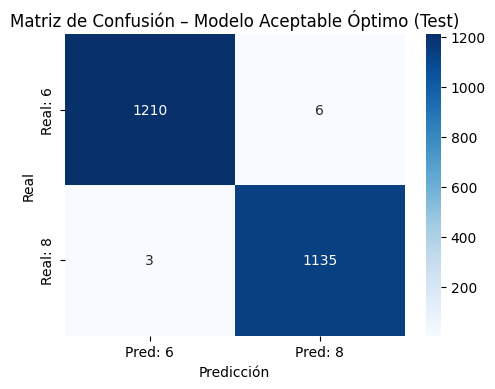

In [ ]:
# ===============================================
# 1) Extraer el mejor learning rate del Grid Search
# ===============================================
best_lr = resultados_lr_aceptable.iloc[0]["lr"]
print("Mejor learning rate encontrado:", best_lr)

# ===============================================
# 2) Entrenar nuevamente el Modelo Aceptable con LR óptimo
# ===============================================
modelo_optimo = Modelo_NN_Aceptable()

history_optimo = train_and_evaluate(
    modelo_optimo,
    train_loader,
    test_loader,
    epochs=5,
    lr=best_lr
)

# ===============================================
# 3) Evaluar modelo óptimo (Train y Test)
# ===============================================
cm_opt_train, acc_opt_train, prec_opt_train, rec_opt_train = evaluar_clasificador(
    modelo_optimo, train_loader, "Train"
)

cm_opt_test, acc_opt_test, prec_opt_test, rec_opt_test = evaluar_clasificador(
    modelo_optimo, test_loader, "Test"
)

# ===============================================
# 4) Imprimir métricas de forma clara
# ===============================================
print("\n========= MÉTRICAS MODELO ACEPTABLE ÓPTIMO =========")
print(f"Learning Rate óptimo: {best_lr}")
print("\n--- TRAIN ---")
print(f"Accuracy Train  : {acc_opt_train:.4f}")
print(f"Precisión Train : {prec_opt_train:.4f}")
print(f"Recall Train    : {rec_opt_train:.4f}")

print("\n--- TEST ---")
print(f"Accuracy Test   : {acc_opt_test:.4f}")
print(f"Precisión Test  : {prec_opt_test:.4f}")
print(f"Recall Test     : {rec_opt_test:.4f}")

# ===============================================
# 5) Graficar matriz de confusión del modelo óptimo
# ===============================================
graficar_matriz_confusion(cm_opt_test,
                          "Matriz de Confusión – Modelo Aceptable Óptimo (Test)")


El modelo aceptable con learning rate óptimo (0.01) logró un excelente equilibrio entre sesgo y varianza, alcanzando 99.62 % de accuracy en test con muy pocos errores entre las clases 6 y 8. La matriz de confusión confirma que generaliza de manera robusta, minimizando falsos positivos (6) y falsos negativos (3).

# Conclusiones

Trabajando con el dataset reducido a las clases 6 y 8 pude observar cómo varía el rendimiento según el modelo: el subajustado alcanzó 98.9% de precisión pero con limitaciones, el aceptable logró el mejor equilibrio con 99,72% en entrenamiento y 99.24% en test, y el sobreajustado llegó a 99,84% en entrenamiento pero con mayor pérdida en el testeo.

Esto me permitió identificar claramente los fenómenos de subajuste y sobreajuste, concluyendo que el **modelo aceptable** fue el que mejor generalizó en un problema donde diferenciar entre 6 y 8 no resulta tan evidente.

# Referencias
- Revisé las clases y notebooks relacionados con el tema.
- Utilicé la documentación de PyTorch como recurso principal.
- Me apoyé en ChatGPT para poder exlicar el proceso y en la creación de los gráficos.